In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")

# <center>Lecture 2: Handling Trajectory Data</center>

<center>MDAnalysis & MOLSSI Workshop - June 2024 - ASU</center>

## Aims and objectives <a class="tocSkip">

- Give a general overview of how MDAnalysis reads coordinate data
- How to programmatically access / use trajectory data with the MDAnalysis API
- How to write out coordinates

## Overview of File IO in MDAnalysis <a class="tocSkip">

Main file IO in MDAnalysis:
  - Topologies
  - Coordinates (single frame & trajectories)
  - Auxilliary ("additional information")
  
Topology & coordinates form the basis of Universe creation

<center><img src="imgs/MDA-overview.png" alt="MDA-overview" style="width: 700px;"/></center>

## Topology files <a class="tocSkip">

- ~ 30 formats supported
- Provides base information about the system
  - e.g. atom names, elements, charges, bonds
- MDAnalysis **does not** parse energy function related terms
- Read only
  - Except for topologies that contain coordinate data (PDB, GRO, etc...)
- Only read once at Universe creation

In [2]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import TPR

u = mda.Universe(TPR)

print(u.atoms.names)

print(u.atoms.charges)

['N' 'H1' 'H2' ... 'NA' 'NA' 'NA']
[-0.30000001  0.33000001  0.33000001 ...  1.          1.
  1.        ]


## Coordinates files <a class="tocSkip">

- ~ 30 coordinate formats supported
  - Extra file formats via [chemfiles](https://github.com/chemfiles/chemfiles.py) converter interface
- Reads both single frame (e.g. MMTF, PQR) and trajectory files (e.g. XTC, DCD, NetCDF)
- MDAnalysis can both read & write
  - ~ 50% coordinate file types have writers
- Iterative IO model
  - Data read from disk frame at a time as requested

<center><img src="imgs/mda-coordinates.png" alt="MDA-orview-of-coordinate-readers" style="width: 700px;"/></center>

## General overview of coordinate IO <a class="tocSkip">

<center><img src="imgs/MDA-CoordinateReading.png" alt="MDA-coordinate-workflow" style="width: 1000px;"/></center>

## Trajectory class: `Universe.trajectory` <a class="tocSkip">

- Main class for trajectory access
  - Makes the Reader fetch the relevant data from disk
  - Works on the basis of frames
- Works as an iterator
- Can be randomly seeked

In [3]:
from MDAnalysis.tests.datafiles import (PRM_NCBOX,
                                        TRJ_NCBOX)

u = mda.Universe(PRM_NCBOX, TRJ_NCBOX)

u.trajectory

<NCDFReader /home/bioc1523/software/mambaforge/install/envs/mda_workshop/lib/python3.11/site-packages/MDAnalysisTests/data/Amber/ace_tip3p.nc with 10 frames of 1398 atoms>

## Trajectory class: `Universe.trajectory` <a class="tocSkip">

- Main class for trajectory access
  - Makes the Reader fetch the relevant data from disk
  - Works on the basis of frames
  - Time is in units of **picoseconds**

In [4]:
print("number of frames: ", u.trajectory.n_frames)

print("current frame: ", u.trajectory.frame)

print("current time: ", u.trajectory.time)

number of frames:  10
current frame:  0
current time:  1.0


## Trajectory class: `Universe.trajectory` <a class="tocSkip">

Trajectories can be randomly seeked.

In [7]:
# trajectories can be seeked
u.trajectory[5]

print("current frame: ", u.trajectory.frame)
print("current time: ", u.trajectory.time)

current frame:  5
current time:  6.0


## Trajectory class: `Universe.trajectory` <a class="tocSkip">

Trajectories work as iterators, so you can loop through them!

In [8]:
# trajectories can be iterated
for ts in u.trajectory:
    print('current frame / time: ', u.trajectory.frame,
          u.trajectory.time)

current frame / time:  0 1.0
current frame / time:  1 2.0
current frame / time:  2 3.0
current frame / time:  3 4.0
current frame / time:  4 5.0
current frame / time:  5 6.0
current frame / time:  6 7.0
current frame / time:  7 8.0
current frame / time:  8 9.0
current frame / time:  9 10.0


## Timestep class `Universe.trajectory.ts` <a class="tocSkip">

- Class that holds the current frame's data
  - Trajectory tells Reader to populate Timestep with a given frame
  - Changes every time the trajectory seeks
- Contains time-dependent information
  - `positions`, `dimensions`, `time`, `frame number`, etc..
- Data is then fed to other parts of the Universe
  - i.e. `AtomGroup.positions` takes a copy of `ts.positions` given atoms

In [9]:
u.trajectory.ts

< Timestep 0 with unit cell dimensions [28.818764 28.278753 27.726164 90.       90.       90.      ] >

## Timestep class `Universe.trajectory.ts` <a class="tocSkip">

- Class that holds the current frame's data
  - Trajectory tells Reader to populate Timestep with a given frame
  - Changes every time the trajectory seeks
- Contains time-dependent information
  - `positions`, `dimensions`, `time`, `frame number`, etc..
- Data is then fed to other parts of the Universe
  - i.e. `AtomGroup.positions` takes a copy of `ts.positions` given atoms

In [10]:
# ts holds time-dependent data like positions and forces

print('positions:\n', u.trajectory.ts.positions)

print('forces:\n', u.trajectory.ts.forces)

positions:
 [[15.249873  12.578178  15.191731 ]
 [14.925511  13.58888   14.944009 ]
 [15.285703  14.3409605 15.645962 ]
 ...
 [ 3.9575078 14.525827  16.14651  ]
 [ 4.6214457 14.670319  15.472312 ]
 [ 4.3571763 14.856422  16.950998 ]]
forces:
 [[  35.912895     7.5411134  -62.774    ]
 [ -90.35279    163.55951     27.480358 ]
 [  18.25486    -50.773525    18.73405  ]
 ...
 [-211.5503    -127.57705     14.248226 ]
 [  65.75678     44.437996   -59.866737 ]
 [  65.71979     47.376717    45.049736 ]]


## Timestep class `Universe.trajectory.ts` <a class="tocSkip">

- Class that holds the current frame's data
  - Trajectory tells Reader to populate Timestep with a given frame
  - Changes every time the trajectory seeks
- Contains time-dependent information
  - `positions`, `dimensions`, `time`, `frame number`, etc..
- Data is then fed to other parts of the Universe
  - i.e. `AtomGroup.positions` takes a copy of `ts.positions` given atoms

In [11]:
# positions are passed to things like AtomGroups
print('position:\n', u.trajectory.ts.positions[0])

print('atomgroup position:\n', u.atoms[0].position)

position:
 [15.249873 12.578178 15.191731]
atomgroup position:
 [15.249873 12.578178 15.191731]


## AtomGroups and UpdatingAtomGroups <a class="tocSkip">

- Main entry point for data is AtomGroup
  - API preferred over `ts`

- AtomGroups are statically defined
  - Atoms don't change
  - Only time-dependent variables change
  
- UpdatingAtomGroups
  - Time dependent selection of atoms
  - Expensive, but can be useful

In [13]:
u.trajectory[0]

# atoms with y coordinates > 1 Angstrom
ag = u.select_atoms(
    'prop y > 1',
    updating=True)

print('atoms: ', ag.n_atoms)

u.trajectory[5]

print('atoms: ', ag.n_atoms)

atoms:  1398
atoms:  1371


## Example: TC5b Trp Cage <a class="tocSkip">

- Implicit solvent simulation of TC5b
  - Makes different folds over time


- Can use NGLView to visualise the trajectory

In [14]:
import nglview as nv

u = mda.Universe('data/TC5b.ff14igb8.HMR.parm7',
                 'data/TC5b.nc')

nv.show_mdanalysis(u)

NGLWidget(max_frame=199)

## Example: TC5b Trp Cage <a class="tocSkip">

- Let's calculate a simple end-to-end alpha-carbon distance over the trajectory
  - Very coarse evaluation of folding

Text(0, 0.5, 'distance (Angstroms)')

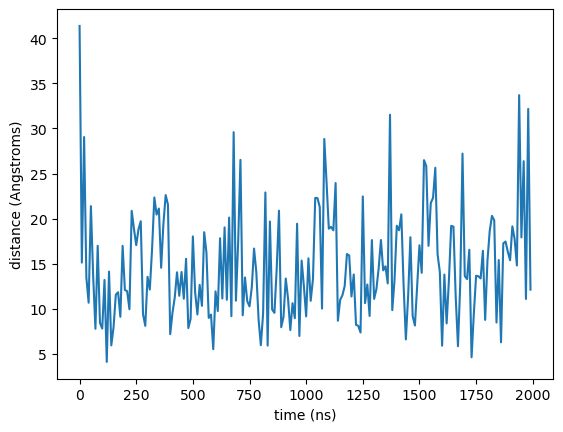

In [15]:
from MDAnalysis.lib.distances import calc_bonds

nterm = u.select_atoms('name CA')[0]
cterm = u.select_atoms('name CA')[-1]

times = np.empty(u.trajectory.n_frames)
distances = np.empty(u.trajectory.n_frames)

for i, ts in enumerate(u.trajectory):
    times[i] = u.trajectory.time / 1000
    distances[i] = calc_bonds(nterm.position,
                              cterm.position)
    
plt.plot(times, distances)
plt.xlabel('time (ns)')
plt.ylabel('distance (Angstroms)')

## I/O Performance Considerations <a class="tocSkip">

- I/O is expensive - minimize wherever possible
- Random seeking can be much more expensive than iterating
- Binary are generally faster to read than ASCII
- Parallelism is an option

## MemoryReader <a class="tocSkip">

- Transferring data to memory speeds up access to trajectory data
  - ~ 1-2 orders of magnitude speedups
  - Requires being able to store data in RAM

- Changes to trajectory data are "permanent"
  - Directly changes the memory object
  - Can be useful
  - example: trajectory aligning (`mda.align.AlignTraj`)
  
- Note: positions from converters (e.g. RDKit, Chemfiles, etc..) are usually MemoryReader instances

## Writing coordinates <a class="tocSkip">

- MDAnalysis implements writers for most coordinate types
- Can directly write from `AtomGroup` or use `MDAnalysis.Writer` class
- Writers will automatically guess file type based on extension
  - Can also pass a `format` keyword to enfore the file type

In [ ]:
# AtomGroup of all atoms
ag = u.atoms

# write out a single frame
ag.write('test.pdb')

# write out all frames
ag.write('test.xtc', frame=all)

## Writing coordinates <a class="tocSkip">

- MDAnalysis implements writers for most coordinate types
- Can directly write from `AtomGroup` or use `MDAnalysis.Writer` class
- Writers will automatically guess file type based on extension
  - Can also pass a `format` keyword to enfore the file type

In [ ]:
# Common to use mda.Writer as a context manager
with mda.Writer('test.dcd', n_atoms=u.atoms.n_atoms,
                format='DCD') as W:
    # Iterate through trajectory to feed the writer
    # in this case - downsample by skipping by 10
    for ts in u.trajectory[::10]:
        W.write(u)

## Review <a class="tocSkip">

- Universes are associated with a Reader when loading coordinates
- `Universe.trajectory` allows for iterating through a trajectory
- `Universe.trajectory.ts` is assigned time-dependent data which is passed to other parts of the Universe
- Writing is achieved through either `AtomGroup.write()` or `MDAnalysis.Write`
- I/O is expensive, transferring to memory can be helpful, but generally try to limit I/O calls

## Session 2 - Practical <a class="tocSkip">

- Notebook `Tutorial2_Trajectories.ipynb`
  - Covers concepts described here
  - Also gives case study examples of how to iterate through trajectories to carry out analyses